In [7]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import control

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

# Identificación de Sistemas Dinámicos en Tiempo Discreto

## Polinomios Autoregresivos (Modelo ARX)

Se hace necesario recalcar que para la Identificación del sistema, se espera reconstruir el modelo a partir de las mediciones de las salidas y entradas. Usando el modelo ARX:

![OL_LTID2](figuras/lti_arx.png)

Usando el modelo de ecuación de error tenemos que:

$$y[k] = -a_1y[k-1]-...-a_{n_a}y[k-{n_a}] + b_1u[k-1]+b_2u[k-2]+...+b_{n_b}u[k-{n_b}] + e[k]$$

El objetivo entonces es obtener el vector de parámetros $\theta = [a_1, a_2,...,a_{n_a}, b_1, b_2,...,b_{n_b}]^T$. Conforme con la relación obtenida para el vector $\theta$, se podría reescribir este modelo así:

$$y[k] = \phi.\theta + e[k]$$

Por tanto para este caso, la matriz de regresión tendría la siguiente forma:

$$\phi = \begin{bmatrix}-y[k-1]&-y[k-2]&...&-y[k-{n_a}]&u[k-1]&u[k-2]&...&u[k-{n_b}]\end{bmatrix}$$

Recordar que del error se pueden introducir los polinomios autoregresivos del modelo ARX:

$$A(z) = 1+a_1z^{-1}+...+a_{n_a}z^{-{n_a}}$$

$$B(z) = b_1z^{-1}+b_2z^{-2}+...+b_{n_b}z^{-{n_b}}$$

Reorganizando entonces:

$$y[k]= \frac{B[z]}{A[z]}u[k] + \frac{1}{A[z]}e[k]$$

$$y[k] = G_e(z)u[k] + H_e(z)e[k]$$

El problema evidente en obtener estas funciones de transferencia estimadas es que se desconoce la naturaleza de la señal $e[k]$, por tanto la señal estimada se debe reconstruir a partir de la función G estimada y el escalón de entrada.

## Ejemplo 1:

Un sistema de segundo orden en tiempo continuo se modela por la siguiente función de transferencia:

$$G(s) = \frac{4}{s^2+2s+4}$$

En un experimento de laboratorio se obtiene su respuesta al escalo unitario con un sensor obteniendo un conjunto de valores $y_n$

Utilice el modelo ARX para determinar una función de transferencia estimada así:

$$G_e(z) = \frac{B(z)}{A(z)}$$



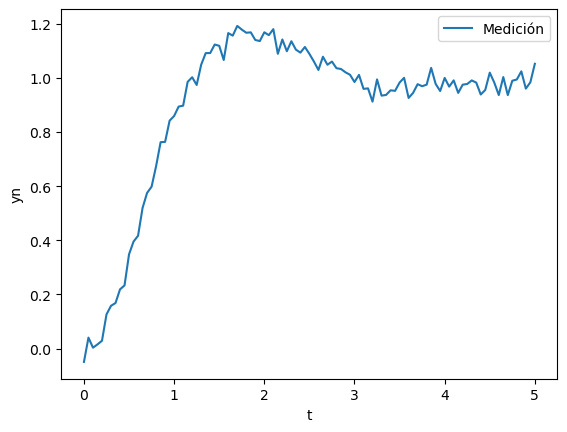

In [50]:
## Sistema de segundo orden en tiempo continuo
#g = control.tf([6],[2,3,9])

g = control.tf([4],[1,2,4])

## Periodo de muestreo y num de muestras para la discretización de la respuesta al escalón
t0 = 0
tf = 5
dt = 0.05
N = int((tf-t0)/dt)+1
t = np.linspace(t0,tf,N)

# Señal de salida ideal "y" y entrada "u"
_,y = control.step_response(g,t)
u = np.ones(N);

## Ruido para simular la señal de salida capturada "yn"
r = 0.03
e = np.random.normal(0,r,size=N)

## Señal de medición de la salida
yn = y+e

## Ceros
z = np.zeros(N);

data = {'unos':np.ones(N),'yn':yn,'u':u,'t':t,'y1':z,'y2':z,'y3':z,'y4':z,'u1':z,'u2':z,'u3':z}

df = pd.DataFrame(data);

sns.lineplot(x = "t", y = "yn", data = df)
plt.legend(['Medición'])


## Definir la matriz de regresión

Para estimar el modelo se debe usar la matriz de regresión lineal, involucrando estados anteriores de la salida y de la entrada.
$$\phi = \begin{bmatrix}-y[k-1]&u[k-1]&u[k-2]&u[k-3]\end{bmatrix}$$

In [88]:
## Crear las versiones resagadas de los datos y1, y2, y3, además de las entradas u,
## dependiendo el sistema que se quiera modelar

df.y1 = df.yn.shift(1)
df.y2 = df.yn.shift(2)
df.y3 = df.yn.shift(3)
df.y4 = df.yn.shift(4)

df.u1 = df.u.shift(1)
df.u2 = df.u.shift(2)
df.u3 = df.u.shift(3)


df = df.fillna(0)

## Creación del vector phi
phi = np.array([-df.y1,-df.y2,df.u1,df.u2,df.u3]).transpose()

## Calculando los parámetros
$$\theta_{ls} = \phi^+.y[k]$$

La regresión lineal continúa siendo el modelo que se está estimando y la estimación de parámetros puede hacerse por los métodos de mínimos cuadrados discutidos con anterioridad. Existirán tantos parámetros como columnas tenga la matriz de regresión.

In [89]:
# Parámetro ALPHA para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.
alpha = 0
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-0.66119796, -0.26718402,  0.07311181, -0.083406  ,  0.08859894])

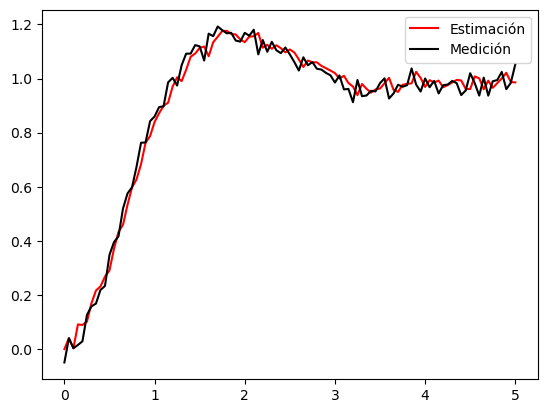

In [90]:
##Reconstrucción de los datos estimados
ye1 = np.dot(phi,theta)
## Graficando las funciones

plt.plot(df.t,ye1,color = 'red')
plt.plot(df.t,df.yn,color = 'black')
plt.legend(['Estimación','Medición'])


## Determinando los polinomios autoregresivos
$$A(z) = 1+a_1z^{-1}+...+a_{n_a}z^{-{n_a}}$$
$$B(z) = b_1z^{-1}+b_2z^{-2}+...+b_{n_b}z^{-{n_b}}$$

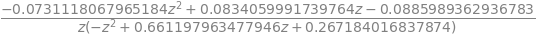

In [100]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)
s = sym.symbols('s', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 + theta[1]*z**-2   
B = theta[2]*z**-1+theta[3]*z**-2+theta[4]*z**-3

## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()
G

## Construir la función estimada en tiempo discreto
$$G_e(z)=\frac{B(z)}{A(z)} = \frac{b_1z^{-1}+b_2z^{-2}+...+b_{n_b}z^{-n_b}}{1+a_1z^{-1}+...+a_{n_a}z^{-n_a}}$$

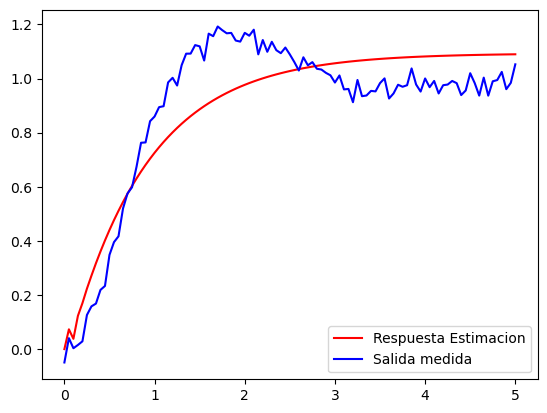

In [94]:
## Se crea el sistema estimado
G_e = control.tf([theta[2],theta[3],theta[4]],[1,theta[0],theta[1],0],dt)

## Se determina la respuesta estimada al escalón
_,ye = control.step_response(G_e,t)


## Graficando las funciones
plt.plot(t,ye,color = 'red')
plt.plot(t,yn,color = 'blue')

plt.legend(['Respuesta Estimacion','Salida medida'])
ECM = np.sqrt(np.dot((yn-ye).transpose(),(yn-ye)))/len(yn)

In [96]:
## Función de transferencia estimada G(z) y error cuadratico medio 
print(G_e)
print(ECM)


0.07311 z^2 - 0.08341 z + 0.0886
--------------------------------
  z^3 - 0.6612 z^2 - 0.2672 z

dt = 0.05

0.01303580624871501


(array([ 0.9441784 +0.j, -0.28298044+0.j,  0.        +0.j]),
 array([0.57040034+0.94152614j, 0.57040034-0.94152614j]))

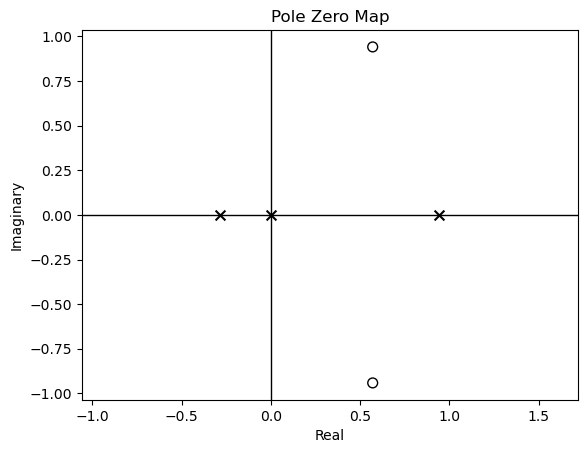

In [97]:
control.pzmap(G_e)

# Estimación en tiempo continuo

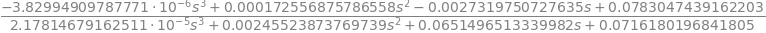

In [103]:
#LLevando el sistema al tiempo continuo haciendo 
#el reemplazo manual de z en función de S

zs = (1+dt/2*s)/(1-dt/2*s)
Gc = G.subs({z:zs}).simplify() 
Gc

In [109]:
## Creando la función de transferencia estimada
## Deben cambiarse por los coeficientes de la salida del bloque anterior

sys = control.tf([0.000172556875786558,-0.0027319750727635,0.0783047439162203],
                 [2.17814679162511*e-5,0.00245523873769739,0.0651496513339982,0.0716180196841805])

_,ye1 = control.step_response(sys,t)

## Graficando las funciones
plt.plot(t,ye,color = 'green')
plt.plot(t,ye1,color = 'red')
plt.plot(t,yn,color = 'blue')

plt.legend(['Estimacion discreta','Estimacion continuo','Salida medida'])


TypeError: The numerator and denominator inputs must be scalars or vectors (for
SISO), or lists of lists of vectors (for SISO or MIMO).